In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn

In [3]:
# Read data
movies = pd.read_csv("movies.csv",
                     usecols=["movieId","title"],
                    dtype={"movieId":"int32", "title":"str"})

movies_2 = pd.read_csv("movies.csv",
                     usecols=["movieId","title"],
                    dtype={"movieId":"int32", "title":"str"})

links = pd.read_csv("links.csv",
                    usecols=["movieId","tmdbId"],
                    dtype={"movieId":"int32"})

ratings = pd.read_csv("ratings.csv",
                    usecols=["userId","movieId","rating"])

# Display the ratings and movies with their tmdbID as well
ratings = pd.merge(ratings,links,on=["movieId"], how="left")
movies = pd.merge(movies,links,on=["movieId"], how="left")

ratings.head()


,userId,movieId,rating,tmdbId
0,1,296,5.0,680.0
1,1,306,3.5,110.0
2,1,307,5.0,108.0
3,1,665,5.0,11902.0
4,1,899,3.5,872.0


In [4]:
movies.head()

,movieId,title,tmdbId
0,1,Toy Story (1995),862.0
1,2,Jumanji (1995),8844.0
2,3,Grumpier Old Men (1995),15602.0
3,4,Waiting to Exhale (1995),31357.0
4,5,Father of the Bride Part II (1995),11862.0


In [5]:
links.head()

,movieId,tmdbId
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0


In [6]:
# Remove those that don't have a tmdbId
ratings['tmdbId'].replace('', np.nan, inplace=True)
ratings.dropna(subset=['tmdbId'], inplace=True)

movies['tmdbId'].replace('', np.nan, inplace=True)
movies.dropna(subset=['tmdbId'], inplace=True)

ratings['tmdbId']=ratings['tmdbId'].astype("int32")
movies['tmdbId']=movies['tmdbId'].astype("int32")

In [7]:
# Gettings the number of votes made by each user and the number of votes each movie receieved
no_user_voted = ratings.groupby('movieId')['rating'].agg('count').reset_index(name='counts')

no_movies_voted = ratings.groupby('userId')['rating'].agg('count').reset_index(name='counts')

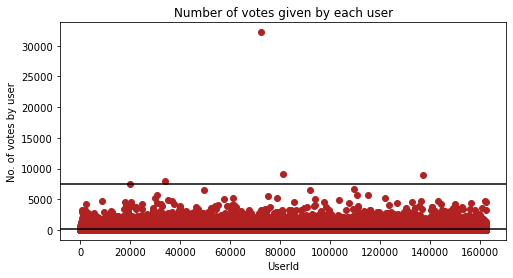

In [10]:
f,ax = plt.subplots(1,1,figsize=(8,4))
plt.scatter(no_movies_voted['userId'],no_movies_voted['counts'],color='#B22222')
plt.axhline(y=200,color='black')
plt.axhline(y=7500,color='black')
plt.title("Number of votes given by each user")
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

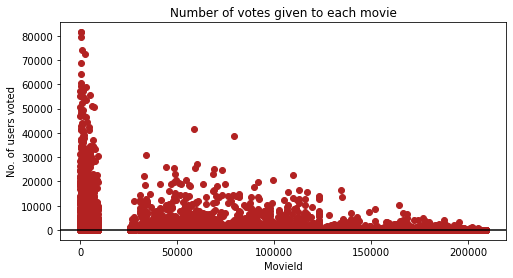

In [9]:
f,ax = plt.subplots(1,1,figsize=(8,4))
plt.scatter(no_user_voted['movieId'],no_user_voted['counts'],color='#B22222')
plt.axhline(y=150,color='black')
plt.title("Number of votes given to each movie")
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [7]:
no_user_voted.head()

,movieId,counts
0,1,57309
1,2,24228
2,3,11804
3,4,2523
4,5,11714


In [8]:
no_movies_voted.head()

,userId,counts
0,1,70
1,2,184
2,3,656
3,4,242
4,5,101


In [9]:
no_user_voted = no_user_voted[no_user_voted['counts'] > 150]
ratings = ratings[ratings['movieId'].isin(no_user_voted['movieId'])]


no_movies_voted = no_movies_voted[no_movies_voted['counts'] > 200]
no_movies_voted = no_movies_voted[no_movies_voted['counts'] < 7500]
ratings = ratings[ratings['userId'].isin(no_movies_voted['userId'])]   

In [10]:
# Preparing the final dataset
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,3,4,12,13,19,23,31,38,43,57,...,162507,162508,162512,162516,162519,162521,162524,162529,162533,162534
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,...,4.0,4.5,4.0,4.5,5.0,4.0,4.5,2.0,4.5,4.0
2,0.0,0.0,2.0,0.0,3.5,0.0,0.0,0.0,3.5,0.0,...,3.0,0.0,3.5,2.5,2.0,0.0,0.0,4.0,4.0,0.0
3,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,3.5,...,4.0,0.0,3.5,0.5,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [11]:
# Convert dataframe of movie features to scipy sparse matrix
from scipy.sparse import csr_matrix

user_movie_matrix = csr_matrix(final_dataset.values)

final_dataset.reset_index(inplace=True)

In [12]:
# Generating the hashmap to convert movieIds to TMDB Ids and vice versa
hashmap = {
    movie: i for i,movie in enumerate(list(movies.set_index("movieId").reindex(final_dataset.movieId).tmdbId))
}
len(hashmap)

8888

In [13]:
# Generating the model
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(user_movie_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [14]:
def get_recommendation(movie_name):
    # We want 10 most similar movies
    no_movies_to_recommend = 10
    checkIds = []
    # Find all movies with the input movie name
    list_of_movies = movies_2[movies_2['title'].str.contains(movie_name)]  
    reverse_map = {v: k for k, v in hashmap.items()}
    results = {}
    
    # If the movie exists
    if len(list_of_movies):
        # We take the movieId of the first movie found
        print("Recommendations for: " + list_of_movies.iloc[0]['title'])
        movie_idx= list_of_movies.iloc[0]['movieId']
        
        # We find the movie ID of it in the final dataset
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        # Using the model to generate movie Ids and distances
        distances , indices = knn.kneighbors(user_movie_matrix[movie_idx],n_neighbors=no_movies_to_recommend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        
        recommendations_df = []
        
        # Printing the results in a dataframe
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies_2[movies_2['movieId'] == movie_idx].index
            recommendations_df.append({'Movie Title':movies_2.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommendations_df,index=range(1,no_movies_to_recommend+1))
        return df.sort_index(ascending=False)
    else:
        return "No movies found. Please check your input"

In [15]:
get_recommendation('Avengers: Age of Ultron')

Recommendations for: Avengers: Age of Ultron (2015)


,Movie Title,Distance
10,Captain America: The Winter Soldier (2014),0.212176
9,Captain America: Civil War (2016),0.257727
8,Ant-Man (2015),0.257986
7,Iron Man 3 (2013),0.266673
6,"Avengers, The (2012)",0.269243
5,Captain America: The First Avenger (2011),0.283726
4,X-Men: Days of Future Past (2014),0.287655
3,Guardians of the Galaxy (2014),0.288036
2,Thor: The Dark World (2013),0.305880
1,Thor (2011),0.320097


In [17]:
get_recommendation('Insidious')

Recommendations for: Insidious (2010)


,Movie Title,Distance
10,Insidious: Chapter 2 (2013),0.379716
9,Sinister (2012),0.390592
8,"Conjuring, The (2013)",0.398301
7,Oculus (2013),0.511742
6,The Conjuring 2 (2016),0.525483
5,Mama (2013),0.534726
4,Insidious: Chapter 3 (2015),0.536979
3,Paranormal Activity (2009),0.539256
2,Orphan (2009),0.541409
1,"Woman in Black, The (2012)",0.547194


In [18]:
get_recommendation('Toy Story 2')

Recommendations for: Toy Story 2 (1999)


,Movie Title,Distance
10,Toy Story (1995),0.233455
9,"Monsters, Inc. (2001)",0.320272
8,"Bug's Life, A (1998)",0.321653
7,Shrek (2001),0.330487
6,Finding Nemo (2003),0.353852
5,"Matrix, The (1999)",0.356461
4,"Lion King, The (1994)",0.360094
3,Men in Black (a.k.a. MIB) (1997),0.363115
2,Back to the Future (1985),0.364828
1,Aladdin (1992),0.370762


In [19]:
get_recommendation('Sydney White')

Recommendations for: Sydney White (2007)


,Movie Title,Distance
10,She's the Man (2006),0.612674
9,"Cinderella Story, A (2004)",0.658268
8,Another Cinderella Story (2008),0.661069
7,John Tucker Must Die (2006),0.666284
6,Aquamarine (2006),0.668778
5,Wild Child (2008),0.675684
4,Ice Princess (2005),0.680209
3,Just My Luck (2006),0.682963
2,What a Girl Wants (2003),0.683626
1,Raise Your Voice (2004),0.689202


In [30]:
get_recommendation('Maze Runner')

Recommendations for: Maze Runner, The (2014)


,Movie Title,Distance
10,Maze Runner: Scorch Trials (2015),0.401590
9,Divergent (2014),0.411792
8,The Hunger Games: Mockingjay - Part 1 (2014),0.446800
7,The Hunger Games: Catching Fire (2013),0.456245
6,The Hunger Games (2012),0.476726
5,Jurassic World (2015),0.476906
4,Guardians of the Galaxy (2014),0.498873
3,Lucy (2014),0.499008
2,Now You See Me (2013),0.502581
1,World War Z (2013),0.503335


### The following code is used to save the required files to be used in Django

In [ ]:
import joblib
import numpy as np


def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)


def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])


def save_model(filename):
    joblib.dump(knn, filename)


def save_hashmap(filename):
    np.save(filename,hashmap)


def saveFiles():
    save_model('knnModel.pkl')
    save_hashmap('movie_tmdb_map.npy')
    save_sparse_csr("sparse_matrix",mat_movie_features)
    

In [ ]:
# saveFiles()